## Feature engineering
### We are going to classify the predictors for price in 3 categories
1. Listing Predictors: everything related to the property, location, space, people it hosts . Is is entire property or room for rent
2. Owner predictors: how responsive is the owner? 
3. Reviews predictos - comments - topics. using BERTopic


In [1]:
#import necessary packages
import pandas as pd

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
#Support for formulas
import statsmodels.formula.api as smf
#Use glm() directly
from statsmodels.formula.api import glm

In [2]:
#read files (chicago)
path1=f"./final_df_lnlm.csv"
df_final = pd.read_csv(path1)


/var/folders/tr/q_709j197n3f6py54vpmh1tw0000gn/T/ipykernel_49863/2206571187.py:3: DtypeWarning: Columns (0,1,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final = pd.read_csv(path1)


In [3]:
df_to_submit = df_final.head(20)


In [6]:
df_to_submit = df_to_submit[['id', 'host_id','city','property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds','price',
       'host_since', 'host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count', 'neighbourhood',
       'neighbourhood_cleansed',  'amenities', 
       'minimum_nights', 'maximum_nights', 'number_of_reviews', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'reviews_per_month',
       'listing_id', 'comments', 'description', 'neighborhood_overview',]]

In [7]:
df_to_submit.to_csv('airbnb_datasample.csv',index=False)

In [3]:
df_final['listing_id'].count()

22242

In [4]:
df_final.columns

Index(['Unnamed: 0', 'id', 'description', 'neighborhood_overview', 'host_id',
       'host_since', 'host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count', 'neighbourhood',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'number_of_reviews', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       '

### DATA CLEANING - NULL VALUES & CORRELATION


### Check for null values in the variables 
#### Before starting any exploration - we will check if there are variables we need to drop or estimate later

In [5]:
# Drop some variables wi ewill not use:
df_final_clean = df_final.drop(['id','Unnamed: 0',
                                'host_location','host_neighbourhood'],axis=1)

In [6]:
df_final_clean['price'] = df_final_clean['price'].str.replace('$', '').str.replace(',', '')
df_final_clean['price'] = df_final_clean['price'].astype('float')

/var/folders/tr/q_709j197n3f6py54vpmh1tw0000gn/T/ipykernel_71905/3168110230.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_final_clean['price'] = df_final_clean['price'].str.replace('$', '').str.replace(',', '')


In [7]:
# Remove properties that are in the 0.05 top price - As they are outliers
df_final_clean = df_final_clean[df_final_clean['price'] < 1000]
df_final_clean = df_final_clean[df_final_clean["minimum_nights"] < 15]
df_final_clean['price'].describe()

count    47022.000000
mean       210.154466
std        166.445684
min          0.000000
25%         95.000000
50%        159.000000
75%        269.000000
max        999.000000
Name: price, dtype: float64

In [8]:
df_final_clean.columns

Index(['description', 'neighborhood_overview', 'host_id', 'host_since',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'neighbourhood',
       'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'number_of_reviews', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'listing_id', 'comments', 'city'],
      dtype='object')

In [9]:
to_plot = df_final_clean[['city','description']].groupby(['city']).count().reset_index()

to_plot

#create pie chart
#plt.pie(to_plot['id'],labels =  list(to_plot['city'].drop_duplicates()) )
#plt.show()

,city,description
0,Chicago,4839
1,Los angeles,22202
2,New York,19256


<AxesSubplot:xlabel='price', ylabel='Count'>

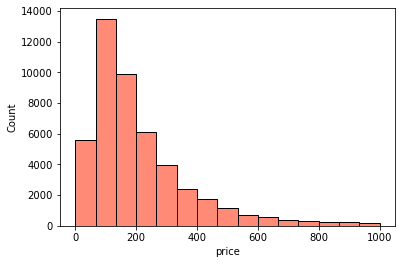

In [10]:

sns.histplot(data=df_final_clean, x="price",bins = 15,color='tomato')

In [11]:
# variables drop : Many null values not a lot of value to add
#df = df.drop(['bathrooms'],axis=1)
import re
df_final_clean['Shared_bathroom'] = np.where(df_final_clean['bathrooms_text'].str.contains('shared'),1,0)
df_final_clean['bathrooms'] = df_final_clean.bathrooms_text.str.extract('(\d+)')
mean_value=df_final_clean['bathrooms'].dropna(how='any').median().astype('int')
df_final_clean['bathrooms'].fillna(value=mean_value, inplace=True)
df_final_clean['bathrooms'] = df_final_clean['bathrooms'].astype('int')

In [12]:
df_final_clean['bathrooms'].describe()

count    47022.000000
mean         1.310472
std          0.679874
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         12.000000
Name: bathrooms, dtype: float64

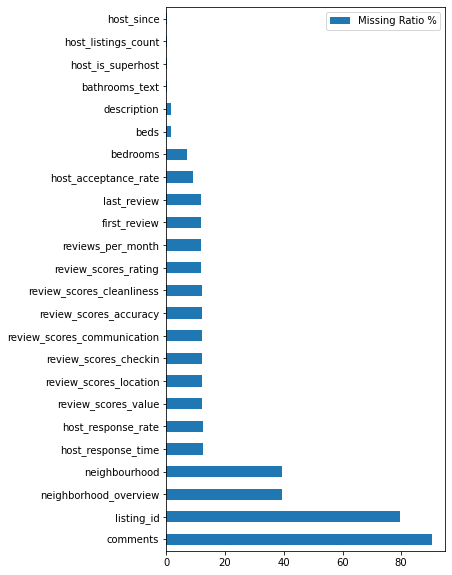

In [13]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,10)
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(df_final_clean)

In [14]:
# Dummy variables 
# property type : room or entire property
entire_property_values=['Shared room','Private room','Hotel room']
df_final_clean['entire_property'] = np.where(df_final_clean['room_type'].isin(entire_property_values),0,1) 

# keep room_type : private vs shared
df_final_clean['room_type'].drop_duplicates()
df_final_clean['shared_room'] = np.where(df_final_clean['room_type'].isin(['Shared room']),1,0) 

In [15]:
print(df_final_clean['room_type'].drop_duplicates())

0         Private room
1      Entire home/apt
53         Shared room
231         Hotel room
Name: room_type, dtype: object


<AxesSubplot:xlabel='entire_property', ylabel='price'>

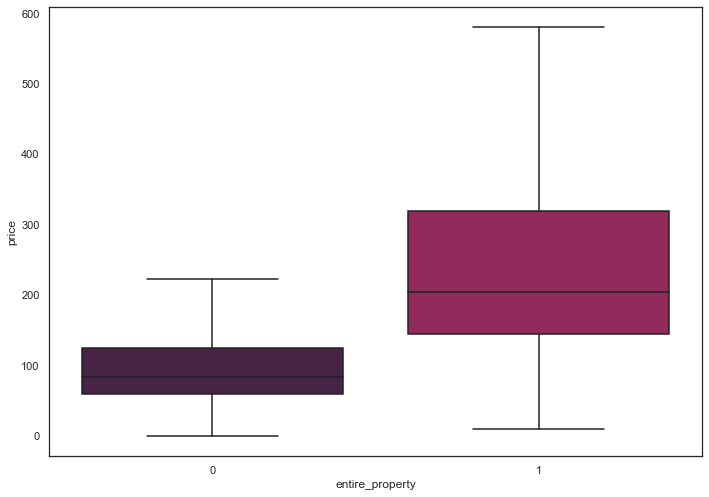

In [16]:
#sns.set_style("white").color_palette("RdPu", 10)
sns.set(rc={'figure.figsize':(11.7,8.27)})

#sequential_colors = sns.color_palette("RdPu", 10)
#sns.palplot(sequential_colors)


#Palette = sns.color_palette("RdPu", 10) #define your preference
sns.set_style("white")
sns.set_palette("rocket",4) #use the list defined in the function
sns.boxplot(data=df_final_clean, 
            x='entire_property', 
            y="price",
            showfliers=False)
           


<AxesSubplot:xlabel='room_type', ylabel='price'>

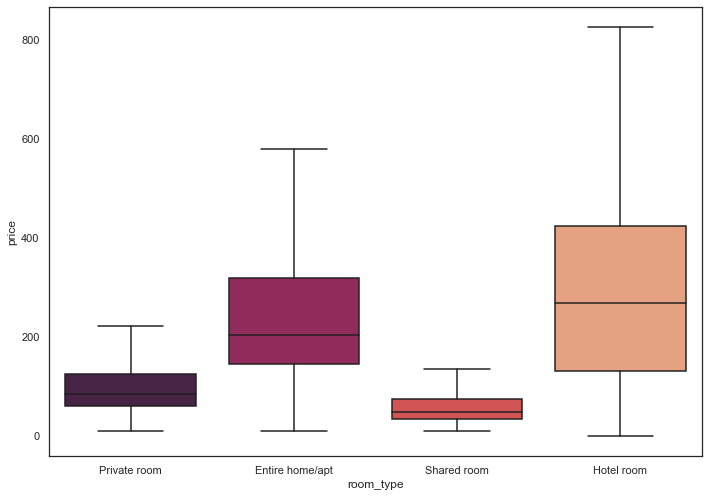

In [17]:
sns.set_style("white")
sns.color_palette("rocket")
sns.boxplot(data=df_final_clean, y="price", x='room_type',showfliers=False,palette="rocket")

In [18]:
df_final_clean = df_final_clean[df_final_clean['room_type'] != 'Hotel room']
df_final_clean.groupby('room_type').count()

,description,neighborhood_overview,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,neighbourhood,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,listing_id,comments,city,Shared_bathroom,entire_property,shared_room
room_type,,,,,,,,,,,,,,,,,,,,,
Entire home/apt,30092,19071,30359,30329,27354,27354,28212,30356,30329,19071,...,30359,30359,30359,27112,6406,3328,30359,30359,30359,30359
Private room,15327,9028,15734,15734,13045,13045,13740,15731,15734,9029,...,15734,15734,15734,13518,3008,1056,15734,15734,15734,15734
Shared room,605,282,622,622,497,497,525,622,622,282,...,622,622,622,496,117,56,622,622,622,622


<AxesSubplot:xlabel='city', ylabel='price'>

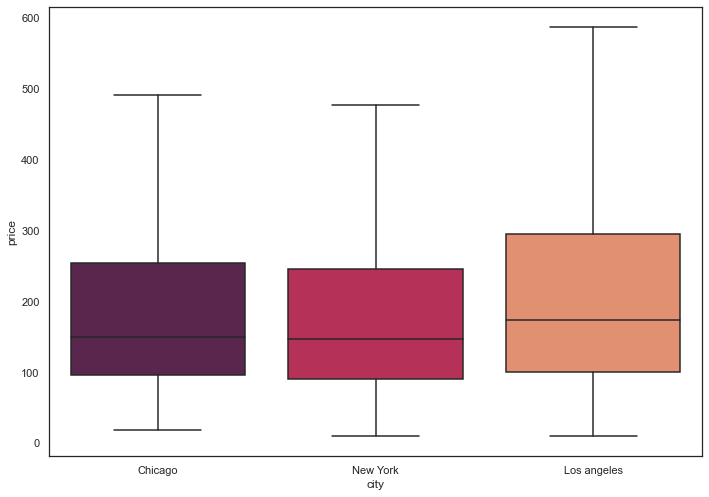

In [19]:
sns.set_style("white")
sns.boxplot(data=df_final_clean, y="price", x='city',showfliers=False,palette="rocket")

### Correlation heat maps - by variable groups

#### Listings predictors

In [20]:
info_Corr_listings = df_final_clean[['price', 'bedrooms', 'minimum_nights',
                                        'accommodates', 'bathrooms','beds','Shared_bathroom','shared_room',
                                    'entire_property']]

corr = info_Corr_listings.corr()
corr.style.background_gradient(cmap='coolwarm')

,price,bedrooms,minimum_nights,accommodates,bathrooms,beds,Shared_bathroom,shared_room,entire_property
price,1.000000,0.579119,0.049166,0.576347,0.473075,0.509734,-0.381311,-0.096783,0.406473
bedrooms,0.579119,1.000000,0.053959,0.824989,0.658622,0.819764,-0.323853,-0.078869,0.433250
minimum_nights,0.049166,0.053959,1.000000,-0.021236,0.040548,0.020709,-0.030195,-0.037196,0.087394
accommodates,0.576347,0.824989,-0.021236,1.000000,0.562807,0.844857,-0.376987,-0.091959,0.466074
bathrooms,0.473075,0.658622,0.040548,0.562807,1.000000,0.564843,-0.112118,0.015528,0.188962
beds,0.509734,0.819764,0.020709,0.844857,0.564843,1.000000,-0.304966,-0.047086,0.392410
Shared_bathroom,-0.381311,-0.323853,-0.030195,-0.376987,-0.112118,-0.304966,1.000000,0.223648,-0.702776
shared_room,-0.096783,-0.078869,-0.037196,-0.091959,0.015528,-0.047086,0.223648,1.000000,-0.158264
entire_property,0.406473,0.433250,0.087394,0.466074,0.188962,0.392410,-0.702776,-0.158264,1.000000


Numeric Listing variables: bedrooms, bathrooms, people accomodates , although too correlated with bedrooms and beds and accomodates - I would just use accomodates.

Final variables: bathrooms, accomodates, Shared_bathroom,shared_room,entire_property,bedrooms

In [21]:
info_Corr_reviews = df_final_clean[['price', 'number_of_reviews', 
                                          'review_scores_rating', 
                                          'review_scores_checkin' ,
                                          'review_scores_cleanliness', 
                                          'review_scores_communication',
                                          'review_scores_location',
                                          'review_scores_value',
                                          ]]

corr = info_Corr_reviews.corr()
corr.style.background_gradient(cmap='coolwarm')

,price,number_of_reviews,review_scores_rating,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value
price,1.000000,-0.089352,0.054912,0.019417,0.065303,0.015597,0.130916,-0.022068
number_of_reviews,-0.089352,1.000000,0.103179,0.109621,0.111586,0.101975,0.076714,0.112270
review_scores_rating,0.054912,0.103179,1.000000,0.746762,0.810910,0.803818,0.653813,0.862492
review_scores_checkin,0.019417,0.109621,0.746762,1.000000,0.636277,0.803934,0.586963,0.696406
review_scores_cleanliness,0.065303,0.111586,0.810910,0.636277,1.000000,0.672204,0.557170,0.749522
review_scores_communication,0.015597,0.101975,0.803818,0.803934,0.672204,1.000000,0.612197,0.754843
review_scores_location,0.130916,0.076714,0.653813,0.586963,0.557170,0.612197,1.000000,0.665232
review_scores_value,-0.022068,0.112270,0.862492,0.696406,0.749522,0.754843,0.665232,1.000000


Reviews seem to be not as important as the listings with location and cleanliness the most important - location seems very important - how can we estimate how good the location is?

In [22]:
# Create some dummys
df_final_clean['instant_bookable'] = np.where(df_final_clean['instant_bookable'] == 'f',0,1)
df_final_clean['host_is_superhost'] = np.where(df_final_clean['host_is_superhost'] == 'f',0,1)
info_Corr_host = df_final_clean[['price', 'host_listings_count','instant_bookable','host_is_superhost']]                                          

#info_Corr_host['host_listings_count'] = info_Corr_host['host_listings_count'].astype('float')
corr = info_Corr_host.corr()
corr.style.background_gradient(cmap='coolwarm')      

,price,host_listings_count,instant_bookable,host_is_superhost
price,1.000000,0.151295,0.054085,0.020746
host_listings_count,0.151295,1.000000,0.114333,-0.058850
instant_bookable,0.054085,0.114333,1.000000,-0.079779
host_is_superhost,0.020746,-0.058850,-0.079779,1.000000


host_listings_count and host_total_listings_count are highly correlated so we should only use one

In [23]:
# Load the regular expression library
import re

vars_for_nlp = ['listing_id','description','comments','neighborhood_overview']

for var in [x for x in vars_for_nlp if x not in ['listing_id']]:
    df_final_clean[var] = df_final_clean[var].astype('str')
    df_final_clean[var] = df_final_clean[var].map(lambda x: re.sub('[,\.!?]', '', x))    
    # Convert the titles to lowercase
    df_final_clean[var] = df_final_clean[var].map(lambda x: x.lower())
    


### LatentDirichletAllocation Topics

#### this will be applied for : 
1. description
2. comments
3. neighborhood_overview

In [24]:
df_for_nlp = df_final_clean[vars_for_nlp]

In [25]:
df_for_nlp.describe(include='all') 

,listing_id,description,comments,neighborhood_overview
count,9.531000e+03,46715,46715,46715
unique,NaN,42106,4441,23690
top,NaN,nan,nan,nan
freq,NaN,691,42275,18334
mean,1.715808e+17,NaN,NaN,NaN
std,2.835701e+17,NaN,NaN,NaN
min,2.384000e+03,NaN,NaN,NaN
25%,2.589190e+07,NaN,NaN,NaN
50%,4.575613e+07,NaN,NaN,NaN
75%,5.596362e+17,NaN,NaN,NaN


In [26]:
pip install stop-words

Note: you may need to restart the kernel to use updated packages.


We have to keep in mind that we only have 6000 comments for the listings. Many listings do not have comments. 


In [27]:
# Stop Words
from stop_words import get_stop_words
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer

# Expand stopwords
stopwords = get_stop_words('english')
airbnb_related_words = ['stay', 'airbnb', 'usa','us','would', 'time','chicago','los','angeles','new','york','nyc','la']
numeric = ['1','2','3','4','5','6','7','8','9','0']
others_to_remove = ['definitely','recommend','br','home','house','really','room','host','hosts','everything']
more_to_remove = [ 'aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 
 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn','check','de','well','will']
stopwords.extend(airbnb_related_words)
stopwords.extend(others_to_remove)
stopwords.extend(more_to_remove)
to_use = df_for_nlp[['comments']].drop_duplicates()



### running LDA on Comments

In [28]:
#count_vect = HashingVectorizer(n_features=2**4, stop_words=stopwords)
count_vect = CountVectorizer(max_df=0.8, min_df=3, stop_words=stopwords)
doc_term_matrix = count_vect.fit_transform(to_use['comments'].values.astype('U'))


In [29]:
lda_model = LatentDirichletAllocation(n_components=2, random_state=42)
lda_model.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=2, random_state=42)

In [30]:
first_topic = lda_model.components_[0]
top_topic_words = first_topic.argsort()[-5:]
for i in top_topic_words:
    print(count_vect.get_feature_names()[i])

parking
neighborhood
perfect
space
apartment


/Users/Jbollini/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [31]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 5 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-5:]])
    print('\n')

Top 5 words for topic #0:
['parking', 'neighborhood', 'perfect', 'space', 'apartment']


Top 5 words for topic #1:
['apartment', 'space', 'also', 'close', 'neighborhood']




In [32]:
topic_values = lda_model.transform(doc_term_matrix)
to_use['Topic_comments'] = topic_values.argmax(axis=1)

In [33]:
df_for_nlp = df_for_nlp.merge(to_use,on=['comments'],how='left')


In [34]:
df_for_nlp.count()

listing_id                9531
description              46715
comments                 46715
neighborhood_overview    46715
Topic_comments           46715
dtype: int64

### running LDA on descriptions


In [35]:
to_use1 = df_for_nlp[['description']].drop_duplicates()
doc_term_matrix1 = count_vect.fit_transform(to_use1['description'].values.astype('U'))
lda_model1 = LatentDirichletAllocation(n_components=2, random_state=120)
lda_model1.fit(doc_term_matrix1)

LatentDirichletAllocation(n_components=2, random_state=120)

In [36]:
first_topic = lda_model1.components_[0]
top_topic_words = first_topic.argsort()[-5:]
for i in top_topic_words:
    print(count_vect.get_feature_names()[i])

parking
guest
access
beach
space


/Users/Jbollini/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
for i,topic in enumerate(lda_model1.components_):
    print(f'Top 5 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-5:]])
    print('\n')

Top 5 words for topic #0:
['parking', 'guest', 'access', 'beach', 'space']


Top 5 words for topic #1:
['bed', 'kitchen', 'bedroom', 'apartment', 'space']




In [38]:
topic_values = lda_model1.transform(doc_term_matrix1)
to_use1['Topic_description'] = topic_values.argmax(axis=1)

In [39]:
df_for_nlp = df_for_nlp.merge(to_use1,on=['description'],how='left')


In [40]:
df_for_nlp.count()

listing_id                9531
description              46715
comments                 46715
neighborhood_overview    46715
Topic_comments           46715
Topic_description        46715
dtype: int64

### Running LDA on neiborhood descriptions

In [41]:
to_use2 = df_for_nlp[['neighborhood_overview']].drop_duplicates()
doc_term_matrix2 = count_vect.fit_transform(to_use2['neighborhood_overview'].values.astype('U'))
lda_model2 = LatentDirichletAllocation(n_components=2, random_state=120)
lda_model2.fit(doc_term_matrix2)

LatentDirichletAllocation(n_components=2, random_state=120)

In [42]:
first_topic = lda_model2.components_[0]
top_topic_words = first_topic.argsort()[-5:]
for i in top_topic_words:
    print(count_vect.get_feature_names()[i])

quiet
street
park
restaurants
neighborhood


/Users/Jbollini/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [43]:
for i,topic in enumerate(lda_model2.components_):
    print(f'Top 5 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-5:]])
    print('\n')

Top 5 words for topic #0:
['quiet', 'street', 'park', 'restaurants', 'neighborhood']


Top 5 words for topic #1:
['restaurants', 'park', 'away', 'miles', 'minutes']




In [44]:
topic_values = lda_model2.transform(doc_term_matrix2)
to_use2['Topic_nh_overview'] = topic_values.argmax(axis=1)

In [45]:
df_for_nlp = df_for_nlp.merge(to_use2,on=['neighborhood_overview'],how='left')

In [46]:
### Merge back with complete 
df_for_nlp.count()

listing_id                9531
description              46715
comments                 46715
neighborhood_overview    46715
Topic_comments           46715
Topic_description        46715
Topic_nh_overview        46715
dtype: int64

In [47]:
# Add the vars comments: 

df_for_nlp['topic_comments_word'] = np.where(df_for_nlp['Topic_comments'] == 0,\
                                           'close_apartment_good',
                                           'space_neighborhood')

df_for_nlp['topic_description_word'] = np.where(df_for_nlp['Topic_description'] == 0,\
                                           'located_access_private_beach_space',
                                           'bed_kitchen_bedroom_space_apartment')


df_for_nlp['topic_nh_overview_word'] = np.where(df_for_nlp['Topic_nh_overview'] == 0,\
                                           'beach_walk_minutes_away',
                                           'park_street_restaurants_bar')


In [48]:
df_for_nlp = df_for_nlp.dropna()

In [49]:
vars_for_nlp = ['listing_id','topic_comments_word','topic_description_word','topic_nh_overview_word']
final_fe_data = df_final_clean.merge(df_for_nlp[vars_for_nlp],on='listing_id',how='left')

<AxesSubplot:xlabel='topic_description_word', ylabel='price'>

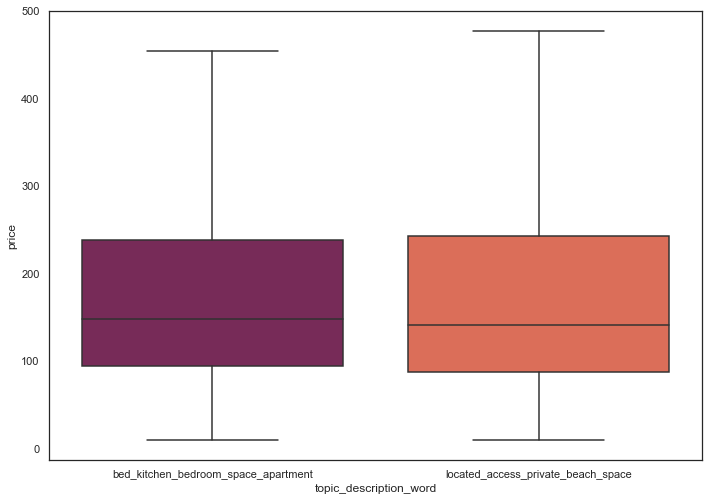

In [50]:
#Is there a difference in price for the different topics found?
topics_var = ['topic_description_word','topic_nh_overview_word','topic_comments_word']
sns.set_style("white")
sns.boxplot(data=final_fe_data, y="price", x='topic_description_word',showfliers=False,palette="rocket")


<AxesSubplot:xlabel='topic_nh_overview_word', ylabel='price'>

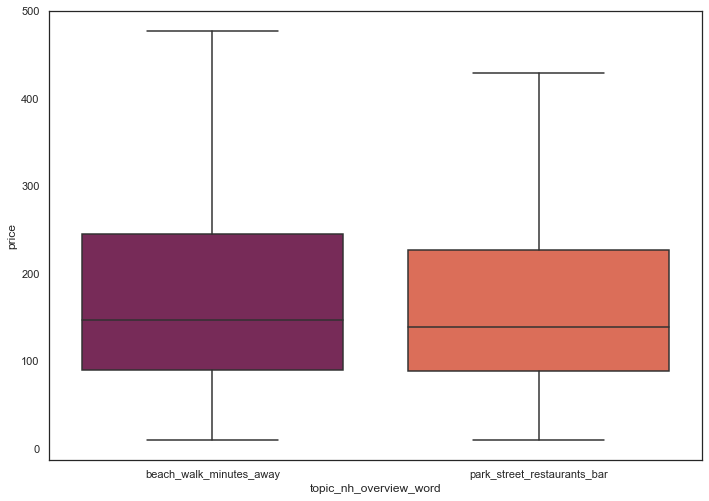

In [51]:
sns.boxplot(data=final_fe_data, y="price", x='topic_nh_overview_word',showfliers=False,palette="rocket")


<AxesSubplot:xlabel='topic_comments_word', ylabel='price'>

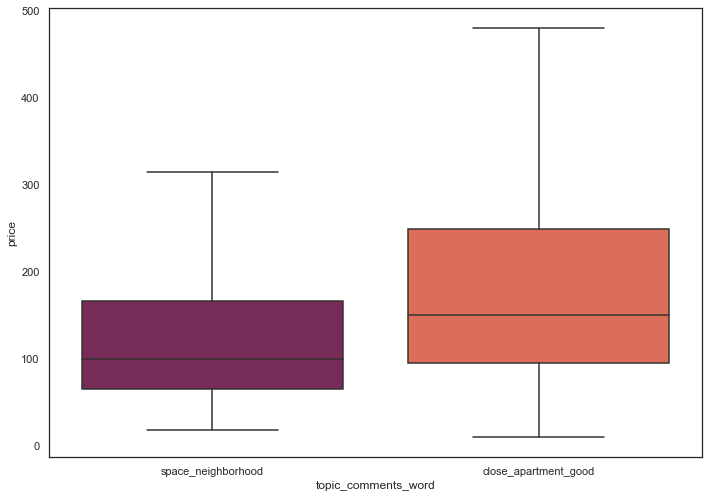

In [52]:
#keep only the topic comments word
sns.boxplot(data=final_fe_data, y="price", x='topic_comments_word',showfliers=False,palette="rocket")


### Get the more often seen ammenities

In [53]:
final_fe_data['amenities'] = final_fe_data['amenities'].str.replace("[{}]", "").str.replace('"', "")
final_fe_data['amenities'].head()

/var/folders/tr/q_709j197n3f6py54vpmh1tw0000gn/T/ipykernel_71905/4175702692.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  final_fe_data['amenities'] = final_fe_data['amenities'].str.replace("[{}]", "").str.replace('"', "")


0    [Hot water kettle, Conditioner, Heating, Hot w...
1    [Room-darkening shades, Hot water kettle, Priv...
2    [Washer, Patio or balcony, Heating, Private en...
3    [Heating, Free parking on premises, Hot water,...
4    [Heating, Free parking on premises, Hot water,...
Name: amenities, dtype: object

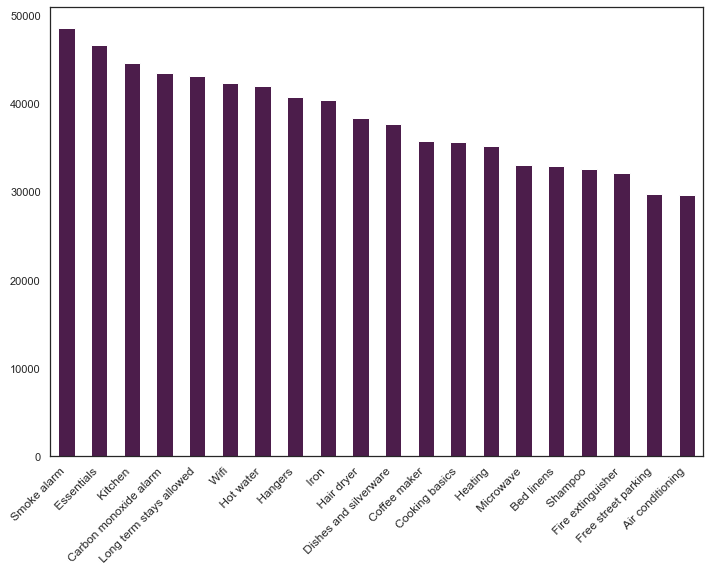

In [54]:
pd.Series(np.concatenate(final_fe_data['amenities'].map(lambda amns: amns.split(","))))\
    .value_counts().head(20)\
    .plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.show()

In [55]:
series_amenities = pd.Series(np.concatenate(final_fe_data['amenities'].map(lambda amns: amns.split(","))))\
    .value_counts().head(400)

lst_amenities = list(series_amenities.index)
lst_amenities = [sub.replace('[', '') for sub in lst_amenities]
lst_amenities = [sub.replace(']', '') for sub in lst_amenities]

lst_amenities = [sub.strip() for sub in lst_amenities]

In [56]:
lst_amenities

['Smoke alarm',
 'Essentials',
 'Kitchen',
 'Carbon monoxide alarm',
 'Long term stays allowed',
 'Wifi',
 'Hot water',
 'Hangers',
 'Iron',
 'Hair dryer',
 'Dishes and silverware',
 'Coffee maker',
 'Cooking basics',
 'Heating',
 'Microwave',
 'Bed linens',
 'Shampoo',
 'Fire extinguisher',
 'Free street parking',
 'Air conditioning',
 'Refrigerator',
 'Dedicated workspace',
 'Extra pillows and blankets',
 'Oven',
 'Stove',
 'TV',
 'Private entrance',
 'Free parking on premises',
 'First aid kit',
 'Cleaning products',
 'Security cameras on property',
 'Dishwasher',
 'Freezer',
 'Dining table',
 'Shower gel',
 'Dryer',
 'Washer',
 'Luggage dropoff allowed',
 'Wine glasses',
 'Hot water kettle',
 'Body soap',
 'Toaster',
 'Room-darkening shades',
 'Laundromat nearby',
 'Lockbox',
 'Lock on bedroom door',
 'Bathtub',
 'Conditioner',
 'BBQ grill',
 'Baking sheet',
 'Outdoor dining area',
 'Outdoor furniture',
 'Private patio or balcony',
 'First aid kit',
 'Refrigerator',
 'Central air c

In [57]:
# Amenities to use in model: 

import warnings
warnings.filterwarnings('ignore')

for am in lst_amenities:
     final_fe_data[am] = np.where(final_fe_data['amenities'].str.contains(am),1,0)

final_fe_data[lst_amenities].describe()

,Smoke alarm,Essentials,Kitchen,Carbon monoxide alarm,Long term stays allowed,Wifi,Hot water,Hangers,Iron,Hair dryer,...,Sauna,Private sauna,Free parking garage on premises \u2013 2 spaces,Shared pool - available all year,tesla only,32\ HDTV,Security cameras on property,TV with,Portable heater,Generic body soap
count,54285.000000,54285.000000,54285.000000,54285.000000,54285.000000,54285.000000,54285.000000,54285.000000,54285.000000,54285.000000,...,54285.000000,54285.000000,54285.0,54285.000000,54285.000000,54285.0,54285.000000,54285.000000,54285.000000,54285.000000
mean,0.944883,0.880483,0.840766,0.852151,0.826490,0.906954,0.782905,0.793221,0.745362,0.780381,...,0.001363,0.001879,0.0,0.001289,0.001271,0.0,0.375776,0.370581,0.029769,0.001253
std,0.228210,0.324399,0.365897,0.354954,0.378691,0.290500,0.412272,0.404999,0.435661,0.413992,...,0.036896,0.043307,0.0,0.035887,0.035630,0.0,0.484327,0.482965,0.169950,0.035371
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [62]:
final_fe_data = final_fe_data.fillna(0)

In [72]:
corr = final_fe_data[['price'] + lst_amenities].corr()['price'][:].sort_values().dropna().drop_duplicates()
corr.to_csv('corr.csv')

<AxesSubplot:xlabel='BBQ grill', ylabel='price'>

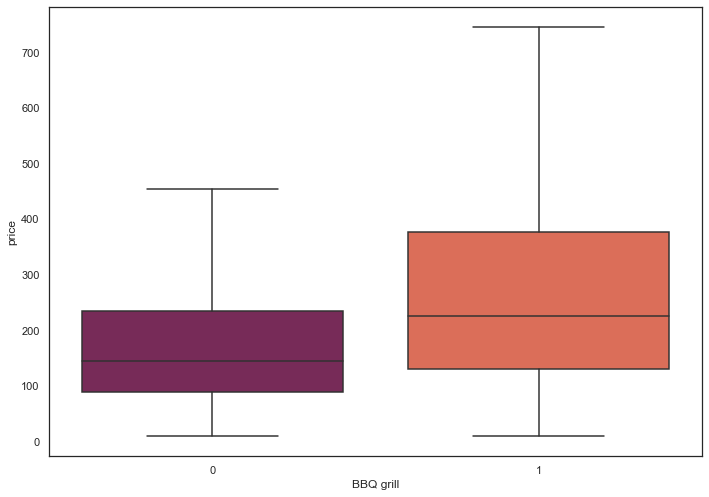

In [70]:
sns.boxplot(data=final_fe_data, y="price", x='BBQ grill',showfliers=False,palette="rocket")

<AxesSubplot:xlabel='Smoke alarm', ylabel='price'>

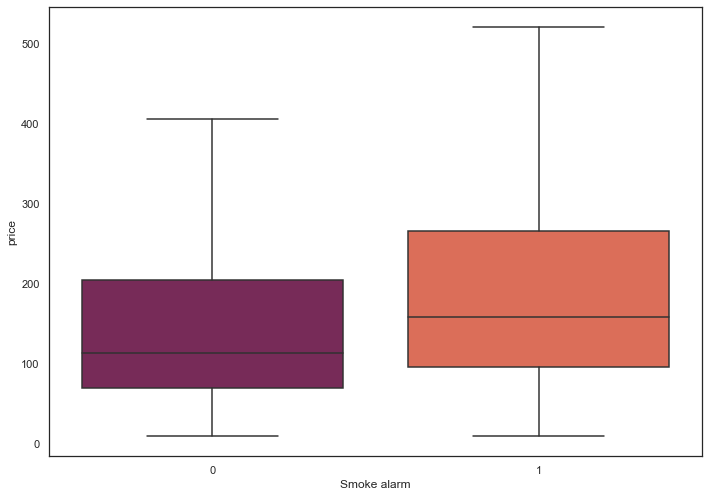

In [73]:
#keep only the topic comments word
sns.boxplot(data=final_fe_data, y="price", x='Smoke alarm',showfliers=False,palette="rocket")


### Categorical Variables - Dummies

In [74]:
#for catvar in Category_predictors:
#    model_data[catvar] = model_data[catvar].astype("category")

for_dm_cat = ["city",'room_type','topic_comments_word']
model_data_dummies = pd.get_dummies(final_fe_data, columns=for_dm_cat)

In [75]:
pd.set_option('display.max_columns', 500)
Stratify_with = ['city_Chicago','city_Los angeles','city_New York']
model_data_dummies[Stratify_with].drop_duplicates()

,city_Chicago,city_Los angeles,city_New York
0,1,0,0
7864,0,0,1
29317,0,1,0


In [76]:
model_data_dummies.to_csv('model_data_dummies.csv',index=False)